In [2]:
from google.colab import userdata
git_token=userdata.get('git_token')
groq_token=userdata.get('groq_api_key')

In [3]:
!pip install Groq pygithub javalang jpype1 agno
!wget -q https://repo1.maven.org/maven2/com/github/javaparser/javaparser-core/3.25.4/javaparser-core-3.25.4.jar -O javaparser-core.jar

In [39]:
from github import Github

g = Github(git_token)
repo = g.get_repo("lx-47/todo-spring")
repo_files = {}

def get_all_files(path):
    contents = repo.get_contents(path, "main")
    for i in contents:
        if i.type == "dir":
            get_all_files(i.path)
        else:
            if i.path.endswith(".java") :
              repo_files[i.path] = i.decoded_content.decode("utf-8")

get_all_files("")



In [40]:
for path, contents in repo_files.items():
  print(path,contents)

src/main/java/com/example/todo/Mapper/TodoMapper.java package com.example.todo.Mapper;


import com.example.todo.dto.TodoResponse;
import com.example.todo.entity.TodoEntity;
import org.springframework.stereotype.Component;

@Component
public class TodoMapper {
    public TodoResponse todoResponse(TodoEntity todoEntity) {
        TodoResponse response = new TodoResponse();
        response.setId(todoEntity.getId());
        response.setTitle(todoEntity.getTitle());
        response.setDescription(todoEntity.getDescription());
        response.setCompleted(todoEntity.isCompleted());
        response.setCreatedAt(todoEntity.getCreatedAt());
        return response;
    }
}

src/main/java/com/example/todo/TodoApplication.java package com.example.todo;

import org.springframework.boot.SpringApplication;
import org.springframework.boot.autoconfigure.SpringBootApplication;

@SpringBootApplication
public class TodoApplication {

	public static void main(String[] args) {
		SpringApplication.run

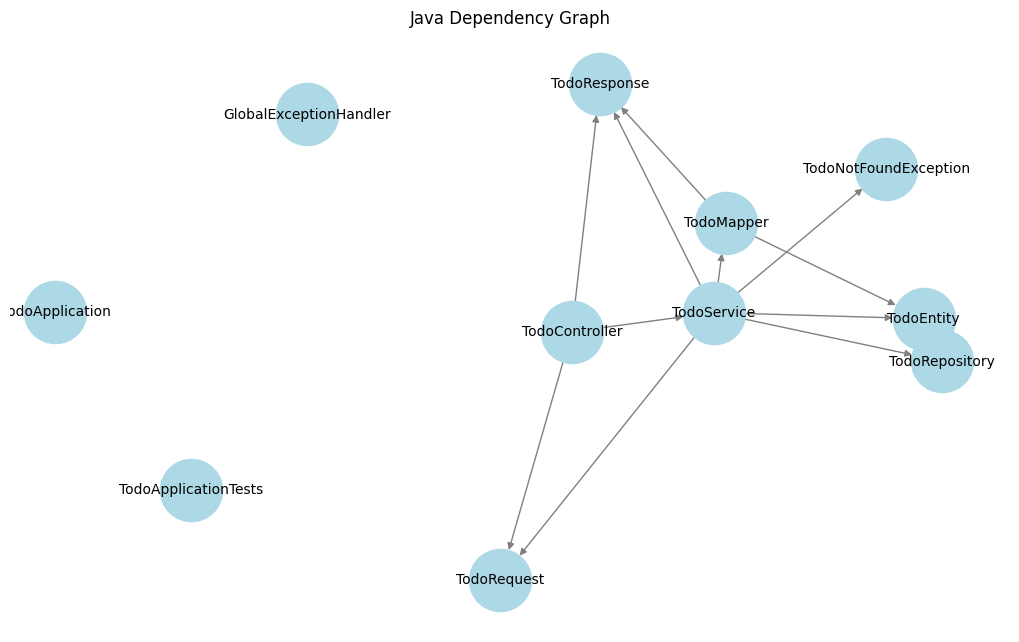

In [6]:
import re
import networkx as nx
import matplotlib.pyplot as plt

# Dictionary `files` already contains Java file paths and their content
# files = { "path/to/File1.java": "content...", "path/to/File2.java": "content..." }

dependency_graph = nx.DiGraph()

# Regex patterns
class_pattern = re.compile(r'\b(class|interface|enum)\s+(\w+)')
import_pattern = re.compile(r'^import\s+([\w.]+);', re.MULTILINE)

# Step 1: Extract class names
class_map = {}  # Map file paths to class names
for path, content in files.items():
    match = class_pattern.search(content)
    if match:
        class_name = match.group(2)
        class_map[path] = class_name
        dependency_graph.add_node(class_name)  # Add as a node

# Step 2: Extract imports and build edges
for path, content in files.items():
    if path in class_map:
        class_name = class_map[path]
        imports = import_pattern.findall(content)

        for imp in imports:
            imported_class = imp.split('.')[-1]  # Get simple class name

            # Check if it's an internal dependency
            if imported_class in class_map.values():
                dependency_graph.add_edge(class_name, imported_class)

# Step 3: Visualize the graph
plt.figure(figsize=(10, 6))
nx.draw(dependency_graph, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
plt.title("Java Dependency Graph")
plt.show()


In [74]:
import javalang

project_summary = {}

def extract_class_info(java_code):
    """Extracts class details, methods, dependencies, and annotations."""
    tree = javalang.parse.parse(java_code)
    class_info = {}

    for _, node in tree:
        if isinstance(node, javalang.tree.ClassDeclaration):
            class_info["name"] = node.name
            class_info["extends"] = node.extends.name if node.extends else None
            class_info["implements"] = [impl.name for impl in node.implements] if node.implements else []
            class_info["methods"] = []
            class_info["fields"] = []
            class_info["dependencies"] = []
            class_info["annotations"] = []
            class_info["imports"] = []

        if isinstance(node, javalang.tree.MethodDeclaration):
            method_summary = {
                "name": node.name,
                "return_type": node.return_type.name if node.return_type else "void",
                "parameters": [(param.type.name, param.name) for param in node.parameters],
            }
            class_info["methods"].append(method_summary)

        if isinstance(node, javalang.tree.FieldDeclaration):
            for declarator in node.declarators:
                class_info["fields"].append({"type": node.type.name, "name": declarator.name})

        if isinstance(node, javalang.tree.MethodInvocation):
            class_info["dependencies"].append(node.member)

        if isinstance(node, javalang.tree.Annotation):
            class_info["annotations"].append(node.name)

        if isinstance(node, javalang.tree.Import):
            import_path = node.path
            if import_path:  # Ensure it's not None
              class_info["imports"].append(import_path)

    return class_info

class_summaries = []

for path, content in repo_files.items():
    try:
        summary = extract_class_info(content)
        class_summaries.append(summary)
        project_summary[path] = summary
    except Exception as e:
        print(f"Error parsing {path}: {e}")



Error parsing src/main/java/com/example/todo/Mapper/TodoMapper.java: 'imports'
Error parsing src/main/java/com/example/todo/TodoApplication.java: 'imports'
Error parsing src/main/java/com/example/todo/controller/TodoController.java: 'imports'
Error parsing src/main/java/com/example/todo/dto/TodoResponse.java: 'imports'
Error parsing src/main/java/com/example/todo/entity/TodoEntity.java: 'imports'
Error parsing src/main/java/com/example/todo/exception/GlobalExceptionHandler.java: 'imports'
Error parsing src/main/java/com/example/todo/repository/TodoRepository.java: 'imports'
Error parsing src/main/java/com/example/todo/service/TodoService.java: 'imports'
Error parsing src/test/java/com/example/todo/TodoApplicationTests.java: 'imports'


In [72]:
for file_path, summary in project_summary.items():
    print("\n" + "="*50)
    print(f"File: {file_path}")
    print("\n")

    # Print Class Name
    print(f"Class: {summary.get('name', 'Unknown')}")

    # Print Imports
    print("\nImports:")
    for imports in summary.get("imports", []):
        print(f"   - {imports}")

    # Print Class Inheritance
    if summary.get("extends"):
        print(f"Extends: {summary['extends']}")
    if summary.get("implements"):
        print(f"Implements: {', '.join(summary['implements'])}")

    # Print Fields (Instance Variables)
    print("\nFields:")
    for field in summary.get("fields", []):
        print(f"   - {field['type']} {field['name']}")

    # Print Methods
    print("\nMethods:")
    for method in summary.get("methods", []):
        param_str = ", ".join([f"{ptype} {pname}" for ptype, pname in method.get("parameters", [])])
        print(f"   - {method['return_type']} {method['name']}({param_str})")

    # Print Dependencies (Referenced Classes)
    print("\nDependencies:")
    for dep in summary.get("dependencies", []):
        print(f"   - {dep}")

    # Print Annotations
    print("\nAnnotations:")
    for annotation in summary.get("annotations", []):
        print(f"   - @{annotation}")


File: src/main/java/com/example/todo/Mapper/TodoMapper.java


Class: TodoMapper

Imports:

Fields:

Methods:
   - TodoResponse todoResponse(TodoEntity todoEntity)

Dependencies:
   - setId
   - getId
   - setTitle
   - getTitle
   - setDescription
   - getDescription
   - setCompleted
   - isCompleted
   - setCreatedAt
   - getCreatedAt

Annotations:
   - @Component

File: src/main/java/com/example/todo/TodoApplication.java


Class: TodoApplication

Imports:

Fields:

Methods:
   - void main(String args)

Dependencies:
   - run

Annotations:
   - @SpringBootApplication

File: src/main/java/com/example/todo/controller/TodoController.java


Class: TodoController

Imports:

Fields:
   - TodoService todoService

Methods:
   - List getAllTodos()
   - TodoResponse createTodo(TodoRequest todoRequest)
   - TodoResponse updateTodo(Long id, TodoRequest todoRequest)
   - void deleteTodo(Long id)

Dependencies:
   - getAllTodos
   - createTodo
   - updateTodo
   - deleteTodo

Annotations:
   - @R

In [9]:
from agno.agent import Agent
from agno.models.groq import Groq
import os
os.environ['GROQ_API_KEY'] = groq_token
file_agent = Agent(
    name="File identifier",
    role="identify changes required in the project",
    model=Groq(id="mistral-saba-24b"),
    instructions=f"""
    You are an expert Spring Boot developer. Your task is to generate new and existing file paths with necessary attributes and methods to add a new feature to the project.
    - Project Summary: {project_summary}
    - New files should be enclosed within <new> and </new>.
    - Existing files requiring updates should be enclosed within <update> and </update>.
    - Only include necessary files.
    - DO NOT GENERATE ANY CODE.
    - Format the response in a concise manner.
    - Follow the example output format below:
      <update>
      ### TodoRequest.java
      To support adding a priority level to the tasks, you need to add a priority field in the request object.
      - **New Fields:**
        - Private `String priority`
      - **New Methods:**
        - `String getPriority()`
        - `void setPriority(String priority)`
      </update>
      <new>
      ### PriorityLevel.java
      Enumerate the priority levels.
        - **Type**: Enum
        - **Values**:
          - `HIGH`
          - `MEDIUM`
          - `LOW`
      </new>
    """,
    )
response = file_agent.run("Add a Task Prioritization feature with three priority levels: High, Medium, and Low for various tasks in the todo list.")
print(response.content)

<update>
### TodoRequest.java
    To support adding a priority level to the tasks, you need to add a priority field in the request object.
    - **New Fields:**
        - Private `PriorityLevel priority`
    - **New Methods:**
        - `PriorityLevel getPriority()`
        - `void setPriority(PriorityLevel priority)`
</update>
<update>
### TodoEntity.java
    To support adding a priority level to the tasks, you need to add a priority field in the entity.
    - **New Fields:**
        - Private `PriorityLevel priority`
    - **New Methods:**
        - `PriorityLevel getPriority()`
        - `void setPriority(PriorityLevel priority)`
</update>
<update>
### TodoResponse.java
    To reflect the changes in the `TodoResponse` to support the new priority level feature.
    - **New Fields:**
        - Private `PriorityLevel priority`
    - **New Methods:**
        - `PriorityLevel getPriority()`
        - `void setPriority(PriorityLevel priority)`
</update>
<update>
### TodoService.java
    T

In [33]:
import re
update_files = re.findall('<update>\s*### (.*?)\n(.*?)(?=\n### |\s*</update>)',response.content, re.DOTALL)
new_files = re.findall('<new>\s*### (.*?)\n(.*?)(?=\n### |\s*</new>)',response.content, re.DOTALL)
files = new_files + update_files
for i in files:
  print(i[0])
  print('\n')
  print(i[1])

PriorityLevel.java


    Enumerate the priority levels.
    - **Type**: Enum
    - **Values**:
      - `HIGH`
      - `MEDIUM`
      - `LOW`
InvalidPriorityLevelException.java


    Custom exception for invalid priority levels.
    - **Type**: Exception
TodoRequest.java


    To support adding a priority level to the tasks, you need to add a priority field in the request object.
    - **New Fields:**
        - Private `PriorityLevel priority`
    - **New Methods:**
        - `PriorityLevel getPriority()`
        - `void setPriority(PriorityLevel priority)`
TodoEntity.java


    To support adding a priority level to the tasks, you need to add a priority field in the entity.
    - **New Fields:**
        - Private `PriorityLevel priority`
    - **New Methods:**
        - `PriorityLevel getPriority()`
        - `void setPriority(PriorityLevel priority)`
TodoResponse.java


    To reflect the changes in the `TodoResponse` to support the new priority level feature.
    - **New Fields:**
   

In [57]:
for i in files:
    for x in repo_files.items():
        if i[0] in x[0]:
            print(x[1])

package com.example.todo.dto;

public class TodoRequest {
    private String title;
    private String description;

    public String getTitle() {
        return title;
    }

    public void setTitle(String title) {
        this.title = title;
    }

    public String getDescription() {
        return description;
    }

    public void setDescription(String description) {
        this.description = description;
    }
}

package com.example.todo.entity;

import jakarta.persistence.*;

import java.time.LocalDateTime;

@Entity
@Table(name = "todos")
public class TodoEntity {
    @Id
    @GeneratedValue(strategy = GenerationType.IDENTITY)
    private Long id;
    private String title;
    private String description;
    private boolean completed;
    private LocalDateTime createdAt;

    // Getters and Setters
    public Long getId() {
        return id;
    }

    public void setId(Long id) {
        this.id = id;
    }

    public String getTitle() {
        return title;
    }

    p

In [60]:
import time
code_generation_agent = Agent(
    name="code generator",
    role="generate the required code based on the prompt",
    model=Groq(id="deepseek-r1-distill-llama-70b"),
    instructions=f"""
    You are an expert Spring Boot developer. Your task is to generate sprint boot code based on the prompt given.
    - Project Summary: {project_summary}
    - Only generate the required code for the file mentioned in the prompt between the tags <result> and </result>.
    - Do not generate unnessary code.
    - DO NOT GENERATE ANY TEXT.
    - Alter the existing code only if required and add comments to explain the changes if made.
    - Follow the output format given below:
    <result>
    ### file_path

    code
    </result>
    """,
    )
for i in files:
  for x in repo_files.items():
    if i[0] in x[0]:
      existing_file = x[1]
    else :
      existing_file = "EMPTY"
  code_response = code_generation_agent.run(f"""
  Generate code for the file {i[0]} with the description {i[1]} and the existing file content {existing_file}
  """)
  print(code_response.content)
  time.sleep(10)

<think>
Okay, I need to generate code for the file PriorityLevel.java based on the given prompt. The prompt says it's an enum with three values: HIGH, MEDIUM, and LOW. The existing file is empty, so I don't have to worry about altering anything. 

First, I'll start by declaring the enum. Since it's a basic enum without any methods or fields beyond the standard, I'll keep it simple. Each value will be in uppercase as per Java conventions.

I'll write the enum declaration with the three specified values. I don't need to add any constructors or methods unless specified, which it isn't. So the code will be straightforward.

I'll make sure the syntax is correct, each enum constant is separated by a comma, and the file ends properly. No additional imports are needed for a basic enum.

That's all. The code should look clean and meet the requirements.
</think>

<result>
### src/main/java/com/example/todo/enum/PriorityLevel.java

public enum PriorityLevel {
    HIGH,
    MEDIUM,
    LOW
}
</res

In [ ]:
def model_to_identify_files(feature,project_summary):
    client = Groq(api_key=groq_token)

    prompt = f"""
    You are an expert springboot developer, your task is to generate new file names and existing file names if required to add a new feature into the project based on the input {feature}.
    - This is a summary about the project that you are working on {project_summary}
    - Generate a description about the use of files and other attributes and functions that will be required under each file name for what that file is required.
    - Generate only new files between the tags <new> and <new>
    - Generate only the existing files to be updated between the tags <update> and <update>
    - Generate the required files only.
    - Do not generate codes
    """

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="mistral-saba-24b",
        temperature=0.1,
        max_tokens=2000
    )
    return chat_completion.choices[0].message.content
# changes = model_to_identify_files(feature="Add a Task Prioritization feature with three priority levels: High, Medium, and Low for various tasks in the todo list.",project_summary=project_summary)
# print(changes)

In [10]:
!pip install agno pygithub anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 6.3 MB/s eta 0:00:00


In [11]:
from agno.agent import Agent
from agno.tools.github import GithubTools
from agno.models.anthropic import Claude
import os
os.environ['GITHUB_ACCESS_TOKEN'] = git_token
os.environ['GITHUB_BASE_URL']="https://api.github.com"
agent = Agent(
    model=Claude(id="claude-3-5-sonnet-20241022"),
    instructions=[
        "Use your tools to answer questions about the repo: agno-agi/agno",
        "Do not create any issues or pull requests unless explicitly asked to do so",
    ],
    tools=[GithubTools()],
    show_tool_calls=True,
)

agent.print_response("List open pull requests", markdown=True)

ERROR    ANTHROPIC_API_KEY not set. Please set the ANTHROPIC_API_KEY environment variable.

Output()

ERROR    Unexpected error calling Claude API: "Could not resolve authentication method. Expected either api_key or 
         auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

WARNING  Attempt 1/1 failed: "Could not resolve authentication method. Expected either api_key or auth_token to be 
         set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

ERROR    Failed after 1 attempts. Last error using Claude(claude-3-5-sonnet-20241022)

ModelProviderError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"